# Fair Housing Project
### Assigned by Bob Gradeck of the Western PA Data Conservancy
Tara Schroth, Stephen Vandrak, Gloria Givler, Annie Goodwin  

### Project Objective
Currently, the affordable housing initiative struggles to place property bids quickly, due to bureaucracy inherent in the organization (working with government resources, etc). Our objective with this project is to establish a list of property owners that may be selling multi-unit properties in the near future. That way, the affordable housing initiative can reach out proactively to these owners and potentially strike a deal to purchase properties before they hit the market.

In [1]:
#import all necessary modules and packages
import pandas as pd
pd.set_option('display.max_rows', None)
from sklearn import datasets
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
import string
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt
!pip install geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="example app")
!pip install plotly
import plotly.express as px

## Importing, cleaning, and merging the datasets

After reading in the sales and assessments datasets and dropping unwanted columns, we wanted to narrow the assessments dataset down to only the properties we are interested in. 

We decided to filter by the feature "USEDESC" (use description). We weren't interested in single-family homes, multi-family homes such as duplexes, condominum units, or any other types of residential properties that could not easily be converted to low-income housing). We decided that we were only interested in properties with the following use descriptions:
- APART:40+ UNITS
- APART:20-39 UNITS
- APART: 5-19 UNITS
- DWG APT CONVERSION


In [2]:
# #11/16/2022
# Read in sales data and look at first 5 rows
sales=pd.read_csv('SalesData.csv', low_memory=False)
sales.head()

PARID  PROPERTYHOUSENUM PROPERTYFRACTION PROPERTYADDRESSDIR  \
0  1075F00108000000              4720                                 NaN   
1  0011A00237000000                 0                                 NaN   
2  0011J00047000000              1903                                 NaN   
3  0113B00029000000               479                                 NaN   
4  0119S00024000000              5417                                 NaN   

  PROPERTYADDRESSSTREET PROPERTYADDRESSSUF PROPERTYADDRESSUNITDESC  \
0             HIGHPOINT                 DR                     NaN   
1               LOMBARD                 ST                     NaN   
2                FORBES                AVE                     NaN   
3             ROOSEVELT                AVE                     NaN   
4               NATRONA                WAY                     NaN   

  PROPERTYUNITNO PROPERTYCITY PROPERTYSTATE  ...                MUNIDESC  \
0            NaN     GIBSONIA            PA  ...               Hampton     
1            NaN   PITTSBURGH            PA  ...   3rd Ward - PITTSBURGH   
2            NaN   PITTSBURGH            PA  ...  1st Ward  - PITTSBURGH   
3            NaN   PITTSBURGH            PA  ...              Bellevue     
4            NaN   PITTSBURGH            PA  ...  10th Ward - PITTSBURGH   

   RECORDDATE    SALEDATE     PRICE DEEDBOOK DEEDPAGE SALECODE  \
0  2012-09-27  2012-09-27  120000.0    15020      356        3   
1  2015-01-06  2015-01-06    1783.0     TR15    00002        2   
2  2012-10-26  2012-10-26    4643.0     TR13      003        2   
3  2017-03-27  2017-03-06       0.0    16739      166        3   
4  2015-02-04  2015-02-04   27541.0     TR15    00059       GV   

                  SALEDESC INSTRTYP     INSTRTYPDESC  
0  LOVE AND AFFECTION SALE       DE             DEED  
1      CITY TREASURER SALE       TS   TREASURER DEED  
2      CITY TREASURER SALE       TS   TREASURER DEED  
3  LOVE AND AFFECTION SALE       CO  CORRECTIVE DEED  
4          GOVERNMENT SALE       TS   TREASURER DEED  

[5 rows x 24 columns]

In [10]:
# Convert sale date from string to date
sales['SALEDATE']=pd.to_datetime(sales['SALEDATE'])

In [5]:
# Read in assessments data and look at first 5 rows
path='C:\\Users\\Tara\\OneDrive - University of Pittsburgh\\FALL 2022\\ENGR 1171\\Project Housing Data\\'

assessment=pd.read_csv(path+'AssessmentData.csv', low_memory=False)
assessment.head()

PARID  PROPERTYHOUSENUM PROPERTYFRACTION      PROPERTYADDRESS  \
0  0001G00104000000               210                   BLVD OF THE ALLIES    
1  0001G00106000000               106                             MARKET ST   
2  0001G00107000000               104                             MARKET ST   
3  0001G00109000000               100                             MARKET ST   
4  0001G00111000000               161                               1ST AVE   

  PROPERTYCITY PROPERTYSTATE PROPERTYUNIT  PROPERTYZIP  MUNICODE  \
0   PITTSBURGH            PA                   15222.0       101   
1   PITTSBURGH            PA                   15222.0       101   
2   PITTSBURGH            PA                   15222.0       101   
3   PITTSBURGH            PA                   15222.0       101   
4   PITTSBURGH            PA                   15222.0       101   

                 MUNIDESC  ...  HALFBATHS HEATINGCOOLING  \
0  1st Ward  - PITTSBURGH  ...        NaN            NaN   
1  1st Ward  - PITTSBURGH  ...        NaN            NaN   
2  1st Ward  - PITTSBURGH  ...        NaN            NaN   
3  1st Ward  - PITTSBURGH  ...        NaN            NaN   
4  1st Ward  - PITTSBURGH  ...        1.0              B   

     HEATINGCOOLINGDESC FIREPLACES BSMTGARAGE FINISHEDLIVINGAREA CARDNUMBER  \
0                   NaN        NaN        NaN                NaN        NaN   
1                   NaN        NaN        NaN                NaN        NaN   
2                   NaN        NaN        NaN                NaN        NaN   
3                   NaN        NaN        NaN                NaN        NaN   
4  Central Heat with AC        NaN        NaN             2011.0        1.0   

  ALT_ID TAXYEAR   ASOFDATE  
0    NaN    2022  01-OCT-22  
1    NaN    2022  01-OCT-22  
2    NaN    2022  01-OCT-22  
3    NaN    2022  01-OCT-22  
4    NaN    2022  01-OCT-22  

[5 rows x 86 columns]

In [6]:
# Drop unwanted columns and look at first 5 rows
assessment=assessment[['PARID','PROPERTYHOUSENUM','PROPERTYFRACTION','PROPERTYADDRESS','PROPERTYUNIT','MUNIDESC','OWNERDESC','CLASSDESC', 
'USEDESC', 'LOTAREA','HOMESTEADFLAG','FARMSTEADFLAG','ABATEMENTFLAG','SALEDATE','SALEPRICE','SALEDESC','PREVSALEDATE','PREVSALEPRICE',
 'PREVSALEDATE2','PREVSALEPRICE2','CHANGENOTICEADDRESS1','CHANGENOTICEADDRESS2','CHANGENOTICEADDRESS3','CHANGENOTICEADDRESS4',
'STYLEDESC','STORIES','YEARBLT','CDUDESC',
]]
assessment.head()

PARID  PROPERTYHOUSENUM PROPERTYFRACTION      PROPERTYADDRESS  \
0  0001G00104000000               210                   BLVD OF THE ALLIES    
1  0001G00106000000               106                             MARKET ST   
2  0001G00107000000               104                             MARKET ST   
3  0001G00109000000               100                             MARKET ST   
4  0001G00111000000               161                               1ST AVE   

  PROPERTYUNIT                MUNIDESC    OWNERDESC    CLASSDESC  \
0               1st Ward  - PITTSBURGH  CORPORATION   COMMERCIAL   
1               1st Ward  - PITTSBURGH  CORPORATION   COMMERCIAL   
2               1st Ward  - PITTSBURGH  CORPORATION   COMMERCIAL   
3               1st Ward  - PITTSBURGH  CORPORATION   COMMERCIAL   
4               1st Ward  - PITTSBURGH      REGULAR  RESIDENTIAL   

                        USEDESC  LOTAREA  ... PREVSALEDATE2 PREVSALEPRICE2  \
0           PARKING GARAGE/LOTS     2280  ...    12-26-1990        50000.0   
1                 RETL/OFF OVER     4680  ...           NaN            NaN   
2  RESTAURANT, CAFET AND/OR BAR     2400  ...    04-14-1997            1.0   
3  RESTAURANT, CAFET AND/OR BAR     4800  ...    04-14-1997            1.0   
4                 SINGLE FAMILY      995  ...    10-14-2015      1754901.0   

          CHANGENOTICEADDRESS1 CHANGENOTICEADDRESS2  CHANGENOTICEADDRESS3  \
0  2020   SMALLMAN ST  STE 301                            PITTSBURGH PA     
1  2020   SMALLMAN ST  STE 301                            PITTSBURGH PA     
2           104   MARKET ST                               PITTSBURGH PA     
3           100   MARKET ST                               PITTSBURGH PA     
4             161   1ST AVE                               PITTSBURGH PA     

  CHANGENOTICEADDRESS4  STYLEDESC  STORIES YEARBLT    CDUDESC  
0                15222        NaN      NaN     NaN        NaN  
1                15222        NaN      NaN     NaN        NaN  
2                15222        NaN      NaN     NaN        NaN  
3                15222        NaN      NaN     NaN        NaN  
4                15222  TOWNHOUSE      1.0  2015.0  EXCELLENT  

[5 rows x 28 columns]

In [7]:
# Narrow it down to properties we’re interested in
# Filter by USEDESC (see above)
assessment=assessment.loc[
    (assessment['USEDESC'].isin(['APART:40+ UNITS','APART:20-39 UNITS','APART:5-19 UNITS','DWG APT CONVERSION']))
]
assessment.head()

PARID  PROPERTYHOUSENUM PROPERTYFRACTION PROPERTYADDRESS  \
68   0001G00043000000               300                      LIBERTY AVE   
203  0001H00363000000               319                          3RD AVE   
206  0001H0037000AU00               301                          3RD AVE   
330  0002G00013000000              1030                          5TH AVE   
461  0002J00260000000               615             -625         2ND AVE   

    PROPERTYUNIT                MUNIDESC    OWNERDESC   CLASSDESC  \
68                1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
203               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
206               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
330               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
461               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   

               USEDESC  LOTAREA  ... PREVSALEDATE2 PREVSALEPRICE2  \
68     APART:40+ UNITS    54798  ...           NaN            NaN   
203    APART:40+ UNITS     8407  ...           NaN            NaN   
206    APART:40+ UNITS        0  ...           NaN            NaN   
330  APART:20-39 UNITS     8064  ...    11-10-1985            1.0   
461    APART:40+ UNITS    28919  ...    08-19-2004           10.0   

          CHANGENOTICEADDRESS1     CHANGENOTICEADDRESS2  CHANGENOTICEADDRESS3  \
68      95  W BEAU ST  STE 600                                WASHINGTON PA     
203  200   DRYDEN RD  STE 2000                                   DRESHER PA     
206     425   6TH AVE  STE 950                                PITTSBURGH PA     
330  1717   ARCH AVE  STE 3820                              PHILADELPHIA PA     
461    125   HIGH ST  STE 2111   ATTN: SCOTT SPELFOGEL            BOSTON MA     

    CHANGENOTICEADDRESS4 STYLEDESC  STORIES YEARBLT  CDUDESC  
68                 15301       NaN      NaN     NaN      NaN  
203                19025       NaN      NaN     NaN      NaN  
206                15219       NaN      NaN     NaN      NaN  
330                19103       NaN      NaN     NaN      NaN  
461                02110       NaN      NaN     NaN      NaN  

[5 rows x 28 columns]

In [25]:
# IGNORE THIS CELL
# Filter by CLASSDESC = Residential
#assessment=assessment.loc[
   # (assessment['CLASSDESC']=='RESIDENTIAL')
#]
#assessment.head()

In [11]:
# Merge the two datasets
# Pull the latest sale date for each property (Tara’s code)
salesgrouped=sales[['PARID','SALEDATE']].groupby('PARID').agg({'SALEDATE':'max'}).reset_index().rename(columns={'SALEDATE':'FINALSALEDATE'})
df=pd.merge(assessment,salesgrouped,how='left',on='PARID')

## Determining the owners that have purchased the most properties in the past 2 years

We wanted to determine who has purchased the most properties in the past 2 years, with the goal of seeing which companies are currently growing their real-estate portfolios. They are less likely to be selling a lot of properties.

In [12]:
# Filter to last 2 years of sales only, look at first 5 rows
last2years=df.loc[df['FINALSALEDATE']>pd.Timestamp('2020-09-22 00:00:00')]
last2years.head()

PARID  PROPERTYHOUSENUM PROPERTYFRACTION PROPERTYADDRESS  \
26  0025N00013000000              2404                      RAILROAD ST   
49  0028F00185000000              3413            -3435      FORBES AVE   
71  0052J00019000000              4601                          5TH AVE   
72  0052J00138000000              4614            -4630         5TH AVE   
73  0028S00136000000              3408                     PARKVIEW AVE   

   PROPERTYUNIT               MUNIDESC     OWNERDESC   CLASSDESC  \
26               2nd Ward - PITTSBURGH   CORPORATION  COMMERCIAL   
49               4th Ward - PITTSBURGH   CORPORATION  COMMERCIAL   
71               4th Ward - PITTSBURGH  REGULAR-ETAL  COMMERCIAL   
72               4th Ward - PITTSBURGH   CORPORATION  COMMERCIAL   
73               4th Ward - PITTSBURGH   CORPORATION  COMMERCIAL   

            USEDESC  LOTAREA  ... PREVSALEPRICE2  \
26  APART:40+ UNITS    31755  ...       200000.0   
49  APART:40+ UNITS    38111  ...      3450000.0   
71  APART:40+ UNITS    31380  ...            NaN   
72  APART:40+ UNITS    40000  ...            NaN   
73  APART:40+ UNITS    38000  ...      1250000.0   

                       CHANGENOTICEADDRESS1 CHANGENOTICEADDRESS2  \
26                  430   PARK AVE  STE 201                        
49                1849   GREEN BAY RD  FL 4                        
71                     1239   MURDOCH RD                           
72         800   WESTCHESTER AVE  STE N-349                        
73  1101  S CAPITAL OF TEXAS HWY  STE B-220                        

   CHANGENOTICEADDRESS3  CHANGENOTICEADDRESS4 STYLEDESC STORIES  YEARBLT  \
26        NEW YORK NY                   10022       NaN     NaN      NaN   
49   HIGHLAND PARK IL                   60035       NaN     NaN      NaN   
71      PITTSBURGH PA                   15217       NaN     NaN      NaN   
72    PORT CHESTER NY                   10573       NaN     NaN      NaN   
73          AUSTIN TX                   78746       NaN     NaN      NaN   

   CDUDESC  FINALSALEDATE  
26     NaN     2021-08-27  
49     NaN     2022-04-13  
71     NaN     2022-07-01  
72     NaN     2021-04-15  
73     NaN     2021-04-06  

[5 rows x 29 columns]

In [13]:
# Find owners who have purchased at least 3 multiunit properties in the last 2 years and look at df
pd.options.mode.chained_assignment = None  # default='warn'
last2years['OwnerInfo']=last2years['CHANGENOTICEADDRESS1'].astype(str)+' '+last2years['CHANGENOTICEADDRESS2'].astype(str)+' '+last2years['CHANGENOTICEADDRESS3'].astype(str)+' '+last2years['CHANGENOTICEADDRESS4'].astype(str)
buyersofmany=last2years[['PARID','OwnerInfo']].drop_duplicates().groupby('OwnerInfo').size().reset_index(name='NumPropertiesBought')
buyersofmany=buyersofmany.loc[(~buyersofmany['OwnerInfo'].isna())&(buyersofmany['NumPropertiesBought']>2)]
last2years.head()

PARID  PROPERTYHOUSENUM PROPERTYFRACTION PROPERTYADDRESS  \
26  0025N00013000000              2404                      RAILROAD ST   
49  0028F00185000000              3413            -3435      FORBES AVE   
71  0052J00019000000              4601                          5TH AVE   
72  0052J00138000000              4614            -4630         5TH AVE   
73  0028S00136000000              3408                     PARKVIEW AVE   

   PROPERTYUNIT               MUNIDESC     OWNERDESC   CLASSDESC  \
26               2nd Ward - PITTSBURGH   CORPORATION  COMMERCIAL   
49               4th Ward - PITTSBURGH   CORPORATION  COMMERCIAL   
71               4th Ward - PITTSBURGH  REGULAR-ETAL  COMMERCIAL   
72               4th Ward - PITTSBURGH   CORPORATION  COMMERCIAL   
73               4th Ward - PITTSBURGH   CORPORATION  COMMERCIAL   

            USEDESC  LOTAREA  ...                     CHANGENOTICEADDRESS1  \
26  APART:40+ UNITS    31755  ...                  430   PARK AVE  STE 201   
49  APART:40+ UNITS    38111  ...                1849   GREEN BAY RD  FL 4   
71  APART:40+ UNITS    31380  ...                     1239   MURDOCH RD      
72  APART:40+ UNITS    40000  ...         800   WESTCHESTER AVE  STE N-349   
73  APART:40+ UNITS    38000  ...  1101  S CAPITAL OF TEXAS HWY  STE B-220   

   CHANGENOTICEADDRESS2 CHANGENOTICEADDRESS3 CHANGENOTICEADDRESS4  STYLEDESC  \
26                             NEW YORK NY                  10022        NaN   
49                        HIGHLAND PARK IL                  60035        NaN   
71                           PITTSBURGH PA                  15217        NaN   
72                         PORT CHESTER NY                  10573        NaN   
73                               AUSTIN TX                  78746        NaN   

   STORIES YEARBLT  CDUDESC FINALSALEDATE  \
26     NaN     NaN      NaN    2021-08-27   
49     NaN     NaN      NaN    2022-04-13   
71     NaN     NaN      NaN    2022-07-01   
72     NaN     NaN      NaN    2021-04-15   
73     NaN     NaN      NaN    2021-04-06   

                                            OwnerInfo  
26     430   PARK AVE  STE 201    NEW YORK NY   10022  
49  1849   GREEN BAY RD  FL 4    HIGHLAND PARK IL ...  
71      1239   MURDOCH RD       PITTSBURGH PA   15217  
72  800   WESTCHESTER AVE  STE N-349    PORT CHEST...  
73  1101  S CAPITAL OF TEXAS HWY  STE B-220    AUS...  

[5 rows x 30 columns]

In [14]:
# Group by the owner to get a list of owners
print('There are', len(buyersofmany), 'owners that have purchased at least three multiunit residential properties in the past 2 years')
buyersofmany.sort_values(['NumPropertiesBought'],ascending=[False])

# Owner's contact info (phone number/primary residence) is not available in the dataset

There are 7 owners that have purchased at least three multiunit residential properties in the past 2 years


OwnerInfo  NumPropertiesBought
32    240  S MAIN ST  STE 2300    NAZARETH PA   18064                   15
5   1  S BROAD ST  STE 1900    PHILADELPHIA PA   1...                    5
48  429   FORBES AVE  STE 1500    PITTSBURGH PA   ...                    5
28    2116   MERRIMAN WAY       PITTSBURGH PA   15203                    4
64  999   WATERSIDE DR  STE 2300    NORFOLK VA   2...                    4
20      1608   ROUTE 88   STE 200    BRICK NJ   08724                    3
33        25   OAK HILL RD       CHAPPAQUA NY   10514                    3

## Determining the owners that currently own the most properties

We wanted to determine who currently owns the most properties, based on the property assessments.

In [15]:
# Look at all data we have
alltime=df
alltime.head()

PARID  PROPERTYHOUSENUM PROPERTYFRACTION PROPERTYADDRESS  \
0  0001G00043000000               300                      LIBERTY AVE   
1  0001H00363000000               319                          3RD AVE   
2  0001H0037000AU00               301                          3RD AVE   
3  0002G00013000000              1030                          5TH AVE   
4  0002J00260000000               615             -625         2ND AVE   

  PROPERTYUNIT                MUNIDESC    OWNERDESC   CLASSDESC  \
0               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
1               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
2               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
3               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
4               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   

             USEDESC  LOTAREA  ... PREVSALEPRICE2       CHANGENOTICEADDRESS1  \
0    APART:40+ UNITS    54798  ...            NaN     95  W BEAU ST  STE 600   
1    APART:40+ UNITS     8407  ...            NaN  200   DRYDEN RD  STE 2000   
2    APART:40+ UNITS        0  ...            NaN     425   6TH AVE  STE 950   
3  APART:20-39 UNITS     8064  ...            1.0  1717   ARCH AVE  STE 3820   
4    APART:40+ UNITS    28919  ...           10.0    125   HIGH ST  STE 2111   

      CHANGENOTICEADDRESS2 CHANGENOTICEADDRESS3  CHANGENOTICEADDRESS4  \
0                               WASHINGTON PA                   15301   
1                                  DRESHER PA                   19025   
2                               PITTSBURGH PA                   15219   
3                             PHILADELPHIA PA                   19103   
4   ATTN: SCOTT SPELFOGEL           BOSTON MA                   02110   

  STYLEDESC STORIES  YEARBLT CDUDESC  FINALSALEDATE  
0       NaN     NaN      NaN     NaN            NaT  
1       NaN     NaN      NaN     NaN     2016-11-16  
2       NaN     NaN      NaN     NaN     2014-06-27  
3       NaN     NaN      NaN     NaN     2015-06-24  
4       NaN     NaN      NaN     NaN     2017-12-22  

[5 rows x 29 columns]

In [16]:
# Find owners who have purchased a multiunit property, ever, and look at df
pd.options.mode.chained_assignment = None  # default='warn'
alltime['OwnerInfo']=alltime['CHANGENOTICEADDRESS1'].astype(str)+' '+alltime['CHANGENOTICEADDRESS2'].astype(str)+' '+alltime['CHANGENOTICEADDRESS3'].astype(str)+' '+alltime['CHANGENOTICEADDRESS4'].astype(str)
ownersofmany=alltime[['PARID','OwnerInfo']].drop_duplicates().groupby('OwnerInfo').size().reset_index(name='NumPropertiesOwned')
ownersofmany=ownersofmany.loc[(~ownersofmany['OwnerInfo'].isna())&(ownersofmany['NumPropertiesOwned']>5)]
alltime.head()

PARID  PROPERTYHOUSENUM PROPERTYFRACTION PROPERTYADDRESS  \
0  0001G00043000000               300                      LIBERTY AVE   
1  0001H00363000000               319                          3RD AVE   
2  0001H0037000AU00               301                          3RD AVE   
3  0002G00013000000              1030                          5TH AVE   
4  0002J00260000000               615             -625         2ND AVE   

  PROPERTYUNIT                MUNIDESC    OWNERDESC   CLASSDESC  \
0               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
1               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
2               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
3               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   
4               1st Ward  - PITTSBURGH  CORPORATION  COMMERCIAL   

             USEDESC  LOTAREA  ...       CHANGENOTICEADDRESS1  \
0    APART:40+ UNITS    54798  ...     95  W BEAU ST  STE 600   
1    APART:40+ UNITS     8407  ...  200   DRYDEN RD  STE 2000   
2    APART:40+ UNITS        0  ...     425   6TH AVE  STE 950   
3  APART:20-39 UNITS     8064  ...  1717   ARCH AVE  STE 3820   
4    APART:40+ UNITS    28919  ...    125   HIGH ST  STE 2111   

      CHANGENOTICEADDRESS2 CHANGENOTICEADDRESS3 CHANGENOTICEADDRESS4  \
0                               WASHINGTON PA                  15301   
1                                  DRESHER PA                  19025   
2                               PITTSBURGH PA                  15219   
3                             PHILADELPHIA PA                  19103   
4   ATTN: SCOTT SPELFOGEL           BOSTON MA                  02110   

   STYLEDESC STORIES YEARBLT  CDUDESC FINALSALEDATE  \
0        NaN     NaN     NaN      NaN           NaT   
1        NaN     NaN     NaN      NaN    2016-11-16   
2        NaN     NaN     NaN      NaN    2014-06-27   
3        NaN     NaN     NaN      NaN    2015-06-24   
4        NaN     NaN     NaN      NaN    2017-12-22   

                                           OwnerInfo  
0    95  W BEAU ST  STE 600    WASHINGTON PA   15301  
1    200   DRYDEN RD  STE 2000    DRESHER PA   19025  
2    425   6TH AVE  STE 950    PITTSBURGH PA   15219  
3  1717   ARCH AVE  STE 3820    PHILADELPHIA PA  ...  
4  125   HIGH ST  STE 2111  ATTN: SCOTT SPELFOGEL...  

[5 rows x 30 columns]

In [17]:
# Group by the owner to get a list of owners
print('There are', len(ownersofmany), 'owners that have bought at least 5 multiunit residential properties, ever')
ownersofmany.sort_values(['NumPropertiesOwned'],ascending=[False])

There are 31 owners that have bought at least 5 multiunit residential properties, ever


OwnerInfo  NumPropertiesOwned
54           PO BOX 81067        PITTSBURGH PA   15217                  34
352  480   LINCOLN HWY       NORTH VERSAILLES PA   ...                  24
201       200   ROSS ST  FL 9    PITTSBURGH PA   15219                  23
273  310   SEVEN FIELDS BLVD  STE 350    MARS PA   ...                  20
133     121   EDGEWOOD AVE       PITTSBURGH PA   15218                  19
220         233   SPAHR ST       PITTSBURGH PA   15232                  18
416        666   5TH AVE  FL 15    NEW YORK NY   10103                  15
236    2500   ELDO RD  STE 1    MONROEVILLE PA   15146                  15
227    240  S MAIN ST  STE 2300    NAZARETH PA   18064                  15
80   100  N BROADWAY   STE 100    SAINT LOUIS MO   ...                  12
189        1823   PENN AVE       PITTSBURGH PA   15221                  12
406  611   WILLIAM PENN PL  STE 800    PITTSBURGH P...                  10
267  301   CHARTIERS AVE       MC KEES ROCKS PA   1...                   9
8             P O BOX  288        INDIANOLA PA   15051                   9
21           PO BOX 11067        PITTSBURGH PA   15237                   9
191    1823   PENN AVE  STE 3    PITTSBURGH PA   15221                   8
20          PO BOX 110040        PITTSBURGH PA   15232                   7
393       5738   BAUM BLVD       PITTSBURGH PA   15206                   7
381  5500   WALNUT ST  STE 300    PITTSBURGH PA   1...                   7
330  429   FORBES AVE  STE 1500    PITTSBURGH PA   ...                   7
301  3700   SOUTH WATER ST  STE 100    PITTSBURGH P...                   7
68           PO BOX 99938        PITTSBURGH PA   15233                   7
171  1670   GOLDEN MILE HWY       MONROEVILLE PA   ...                   7
442       848  W NORTH AVE       PITTSBURGH PA   15233                   7
293  3535   BLVD OF THE ALLIES        PITTSBURGH PA...                   6
85   100  W STATION SQUARE DR  STE 350    PITTSBURG...                   6
60           PO BOX 81917        PITTSBURGH PA   15217                   6
365       515  S AIKEN AVE       PITTSBURGH PA   15232                   6
244      262   FREEPORT RD       PITTSBURGH PA   15238                   6
96   1080   PITTSFORD VICTOR RD  STE 100    PITTSFO...                   6
48           PO BOX 609        SOUTHEASTERN PA   19399                   6

# Remove buyers of many from owners of many
We are interested in companies who currently own a lot of multiunit properties, but aren't recently buying a lot more multiunit properties. We want to eliminate those individuals, as they are more likely to be competitors of the fair housing initiative in terms of placing bids on new properties.

In [19]:
#merging the dataframes and dropping duplicates, printing the list
(ownersofmany.merge(buyersofmany, on='OwnerInfo', how='left', indicator=True)
     .query('_merge == "left_only"')
     .drop('_merge', 1))
print('There are', len(interestingowners), 'owners that have bought at least 5 multiunit residential properties, fewer than 3 of which were bought in the last year')
interestingowners.sort_values(['NumPropertiesOwned'],ascending=[False])

There are 28 owners that have bought at least 5 multiunit residential properties, fewer than 3 of which were bought in the last year


C:\Users\glori\AppData\Local\Temp\ipykernel_15440\3066058120.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (ownersofmany.merge(buyersofmany, on='OwnerInfo', how='left', indicator=True)


OwnerInfo  NumPropertiesOwned
4           PO BOX 81067        PITTSBURGH PA   15217                  34
23  480   LINCOLN HWY       NORTH VERSAILLES PA   ...                  24
13       200   ROSS ST  FL 9    PITTSBURGH PA   15219                  23
19  310   SEVEN FIELDS BLVD  STE 350    MARS PA   ...                  20
9      121   EDGEWOOD AVE       PITTSBURGH PA   15218                  19
14         233   SPAHR ST       PITTSBURGH PA   15232                  18
28        666   5TH AVE  FL 15    NEW YORK NY   10103                  15
16    2500   ELDO RD  STE 1    MONROEVILLE PA   15146                  15
7   100  N BROADWAY   STE 100    SAINT LOUIS MO   ...                  12
11        1823   PENN AVE       PITTSBURGH PA   15221                  12
27  611   WILLIAM PENN PL  STE 800    PITTSBURGH P...                  10
18  301   CHARTIERS AVE       MC KEES ROCKS PA   1...                   9
0            P O BOX  288        INDIANOLA PA   15051                   9
2           PO BOX 11067        PITTSBURGH PA   15237                   9
12    1823   PENN AVE  STE 3    PITTSBURGH PA   15221                   8
1          PO BOX 110040        PITTSBURGH PA   15232                   7
10  1670   GOLDEN MILE HWY       MONROEVILLE PA   ...                   7
6           PO BOX 99938        PITTSBURGH PA   15233                   7
21  3700   SOUTH WATER ST  STE 100    PITTSBURGH P...                   7
25  5500   WALNUT ST  STE 300    PITTSBURGH PA   1...                   7
26       5738   BAUM BLVD       PITTSBURGH PA   15206                   7
29       848  W NORTH AVE       PITTSBURGH PA   15233                   7
17      262   FREEPORT RD       PITTSBURGH PA   15238                   6
8   100  W STATION SQUARE DR  STE 350    PITTSBURG...                   6
20  3535   BLVD OF THE ALLIES        PITTSBURGH PA...                   6
5           PO BOX 81917        PITTSBURGH PA   15217                   6
24       515  S AIKEN AVE       PITTSBURGH PA   15232                   6
3           PO BOX 609        SOUTHEASTERN PA   19399                   6

### Note: the code block below is optional!

Only run the code block below if you have new houses and need their coordinates!

In [21]:
# Pull the addresses of all properties owned by the above owners
assessmentcopy=pd.read_csv(path+'AssessmentData.csv')
ownerproperties=df.loc[df['OwnerInfo'].isin(interestingowners['OwnerInfo'])]
assessmentcopy=assessmentcopy.loc[assessmentcopy['PARID'].isin(ownerproperties['PARID'])]
assessmentcopy['Address']=assessmentcopy['PROPERTYHOUSENUM'].astype(str)+' '+assessmentcopy['PROPERTYADDRESS'].astype(str)+' '+assessmentcopy['PROPERTYCITY'].astype(str)+' '+assessmentcopy['PROPERTYSTATE'].astype(str)+' '+assessmentcopy['PROPERTYZIP'].astype(int).astype(str)
housestomap=assessmentcopy[['PARID','Address']]

C:\Users\Tara\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,29,30,37,38,46,57,83) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Use geopy to get the lat and lon coordinates for each house so we can map them
housestomap['Lat']=''
housestomap['Lon']=''
housestomap=housestomap.reset_index()
for i in range(len(housestomap['Address'])):
    print(i)
    data=geolocator.geocode(housestomap.loc[i,'Address'])
    try:
        housestomap.loc[i,'Lat']=data.raw.get("lat")
        housestomap.loc[i,'Lon']=data.raw.get("lon")
    except:
        continue
housestomap.to_csv('housestomap.csv')


In [29]:
# We had to manually fill in some of the coordinates, hence the read.csv
housestomap=pd.read_csv('housestomap.csv')

In [30]:
# Merge the owner address and number of properties owned with the coordinates
mergedhousestomap=pd.merge(housestomap,df[['PARID','OwnerInfo']],how='left',on='PARID')

In [31]:
#Examine the Owners of Many dataframe
ownersofmany

OwnerInfo  NumPropertiesOwned
8             P O BOX  288        INDIANOLA PA   15051                   9
20          PO BOX 110040        PITTSBURGH PA   15232                   7
21           PO BOX 11067        PITTSBURGH PA   15237                   9
48           PO BOX 609        SOUTHEASTERN PA   19399                   6
54           PO BOX 81067        PITTSBURGH PA   15217                  34
60           PO BOX 81917        PITTSBURGH PA   15217                   6
68           PO BOX 99938        PITTSBURGH PA   15233                   7
80   100  N BROADWAY   STE 100    SAINT LOUIS MO   ...                  12
85   100  W STATION SQUARE DR  STE 350    PITTSBURG...                   6
96   1080   PITTSFORD VICTOR RD  STE 100    PITTSFO...                   6
133     121   EDGEWOOD AVE       PITTSBURGH PA   15218                  19
171  1670   GOLDEN MILE HWY       MONROEVILLE PA   ...                   7
189        1823   PENN AVE       PITTSBURGH PA   15221                  12
191    1823   PENN AVE  STE 3    PITTSBURGH PA   15221                   8
201       200   ROSS ST  FL 9    PITTSBURGH PA   15219                  23
220         233   SPAHR ST       PITTSBURGH PA   15232                  18
227    240  S MAIN ST  STE 2300    NAZARETH PA   18064                  15
236    2500   ELDO RD  STE 1    MONROEVILLE PA   15146                  15
244      262   FREEPORT RD       PITTSBURGH PA   15238                   6
267  301   CHARTIERS AVE       MC KEES ROCKS PA   1...                   9
273  310   SEVEN FIELDS BLVD  STE 350    MARS PA   ...                  20
293  3535   BLVD OF THE ALLIES        PITTSBURGH PA...                   6
301  3700   SOUTH WATER ST  STE 100    PITTSBURGH P...                   7
330  429   FORBES AVE  STE 1500    PITTSBURGH PA   ...                   7
352  480   LINCOLN HWY       NORTH VERSAILLES PA   ...                  24
365       515  S AIKEN AVE       PITTSBURGH PA   15232                   6
381  5500   WALNUT ST  STE 300    PITTSBURGH PA   1...                   7
393       5738   BAUM BLVD       PITTSBURGH PA   15206                   7
406  611   WILLIAM PENN PL  STE 800    PITTSBURGH P...                  10
416        666   5TH AVE  FL 15    NEW YORK NY   10103                  15
442       848  W NORTH AVE       PITTSBURGH PA   15233                   7

In [32]:
# Create a new df that adds on the number of properties owned by each owner
mergedhousestomap2=pd.merge(mergedhousestomap,interestingowners,how='left',on='OwnerInfo')

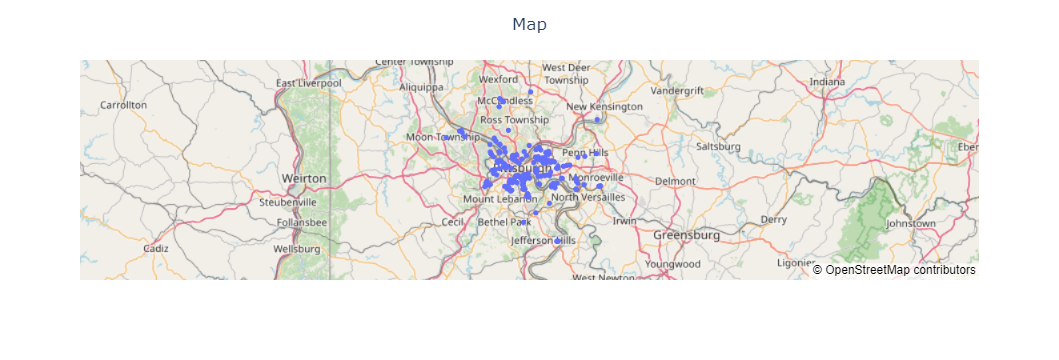

In [33]:
# Create a regular map of all the houses
fig = px.scatter_mapbox(mergedhousestomap,lat='Lat',lon='Lon', hover_name="OwnerInfo")
fig.update_layout(title = 'Map', title_x=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

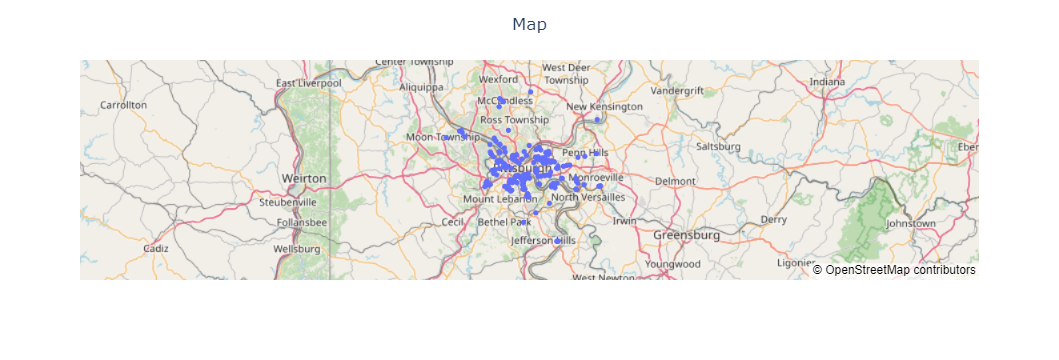

In [35]:
# Map properties of each of the owners in a different color (colors are arbitrary)
fig = px.scatter_mapbox(mergedhousestomap,lat='Lat',lon='Lon', hover_name="OwnerInfo",color='OwnerInfo')
fig.update_layout(title = 'Map', title_x=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(showlegend=False)
fig.show()

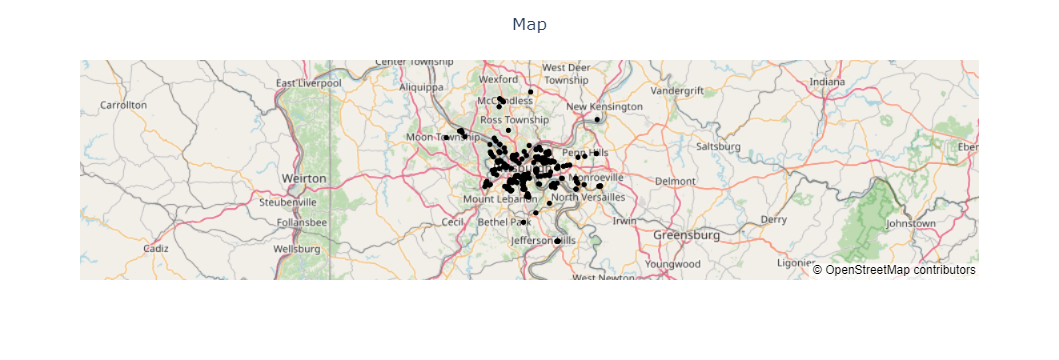

In [36]:
# Map where the houses are, color coded by how many properties their owner owns
fig = px.scatter_mapbox(mergedhousestomap2,lat='Lat',lon='Lon', hover_name="OwnerInfo",color='NumPropertiesOwned',color_continuous_scale='Bluered_r')
fig.update_layout(title = 'Map', title_x=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(showlegend=False)
fig.show()

Cells Below are Full of Ideas and Code Bits, Need to Be Resolved or Deleted

#keep:
['PARID','PROPERTYHOUSENUM','PROPERTYFRACTION','PROPERTYADDRESS','PROPERTYUNIT','MUNIDESC','OWNERDESC','CLASSDESC',
 'LOTAREA','HOMESTEADFLAG','FARMSTEADFLAG','ABATEMENTFLAG','SALEDATE','SALEPRICE','SALEDESC','PREVSALEDATE','PREVSALEPRICE',
 'PREVSALEDATE2','PREVSALEPRICE2','CHANGENOTICEADDRESS1','CHANGENOTICEADDRESS2','CHANGENOTICEADDRESS3','CHANGENOTICEADDRESS4',
'STYLEDESC','STORIES','YEARBLT','CDUDESC'
]
#maybe:
['TAXDESC','USEDESC','RECORDDATE']

In [2]:
# I THINK THIS WHOLE ONE IS DELETABLE
#read in data
sales=pd.read_csv(r'C:\Users\Tara\OneDrive - University of Pittsburgh\FALL 2022\ENGR 1171\Project Housing Data\SalesData.csv')
#convert sale date from string to date
sales['SALEDATE']=pd.to_datetime(sales['SALEDATE'])
assessment=pd.read_csv(r'C:\Users\Tara\OneDrive - University of Pittsburgh\FALL 2022\ENGR 1171\Project Housing Data\AssessmentData.csv')

C:\Users\Tara\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Tara\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,29,30,37,38,46,57,83) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [74]:
#add flag to assessment data of whether a house is in the sales dataset
assessment['Sold']=''
assessment.loc[assessment['PARID'].isin(sales['PARID']),'Sold']=1
assessment.loc[~assessment['PARID'].isin(sales['PARID']),'Sold']=0

In [75]:
#isolate most recent sale date for each house sold, merge onto assessment dataset
salesgrouped=sales[['PARID','SALEDATE']].groupby('PARID').agg({'SALEDATE':'max'}).reset_index().rename(columns={'SALEDATE':'FINALSALEDATE'})
df=pd.merge(assessment,salesgrouped,how='left',on='PARID')

In [78]:
#add number of times property was sold
df=pd.merge(df,sales.groupby('PARID').size().reset_index(name='NumTimesSold'),how='left',on='PARID')
df['NumTimesSold']=df['NumTimesSold'].fillna(0)

In [80]:
#identify possible investor-owned properties
df['PossibleInvestor']=''
df.loc[(df['CHANGENOTICEADDRESS1'].str.replace(" ", "")!=(df['PROPERTYHOUSENUM'].astype(str)+df['PROPERTYADDRESS']).str.replace(" ", ""))&(df['HOMESTEADFLAG'].isna()),'PossibleInvestor']=1
df.loc[df['PossibleInvestor']!=1,'PossibleInvestor']=0

In [81]:
#add multi-parcel sale flag
df['MultiParcel']=''
df.loc[df['PARID'].isin(sales.loc[sales['SALEDESC']=='MULTI-PARCEL SALE']['PARID']),'MultiParcel']=1
df.loc[df['MultiParcel']!=1,'MultiParcel']=0

In [82]:
#get a list of all unique property owners
#make a unique id for each property owner, add it to the main data
df['Ownerinfo']=df['CHANGENOTICEADDRESS1'].astype(str)+df['CHANGENOTICEADDRESS2'].astype(str)+df['CHANGENOTICEADDRESS3'].astype(str)+df['CHANGENOTICEADDRESS4'].astype(str)
allowners=df[['Ownerinfo']].drop_duplicates().reset_index()
allowners['OwnerId']=allowners.index
allowners=allowners[['Ownerinfo','OwnerId']]
df=pd.merge(df,allowners,how='left',on='Ownerinfo')

In [86]:
#get the number of times each owner has sold a property, merge onto original dataset
#only keep data of owners that have a sale in the dataset
ownerssold=df.groupby('OwnerId').agg({'Sold':'sum'}).reset_index().rename(columns={'Sold':'TotalOwnerSales'})
df=pd.merge(df,ownerssold,how='left',on='OwnerId')
df=df.loc[df['TotalOwnerSales']>0]

In [88]:
#pick out some interesting columns
df=df[['PARID','MUNIDESC','OWNERDESC','CLASSDESC',
 'SALEDATE','SALEPRICE','SALEDESC','PREVSALEDATE','PREVSALEPRICE',
 'PREVSALEDATE2','PREVSALEPRICE2',
'STYLEDESC','YEARBLT','GRADEDESC','Sold','FINALSALEDATE','NumTimesSold','TotalOwnerSales','OwnerId','PossibleInvestor','MultiParcel'
]]

In [111]:
#identify 4579 owners that may be of interest
xx=df.loc[(df['OWNERDESC']!='CORPORATION')&(df['TotalOwnerSales']>2)&(df['SALEDESC']!='LOVE&AFFECTION')][['OwnerId','TotalOwnerSales']].drop_duplicates().sort_values('TotalOwnerSales')
yy=df.groupby('OwnerId').agg({'FINALSALEDATE':'max'}).reset_index()
pd.merge(xx,yy,how='left',on='OwnerId').sort_values(['TotalOwnerSales','FINALSALEDATE'])

OwnerId  TotalOwnerSales FINALSALEDATE
2269     4396                3    2012-01-12
1984    32333                3    2012-01-27
1657    36926                3    2012-02-10
426     60351                3    2012-02-17
1819    38601                3    2012-02-27
...       ...              ...           ...
4574     1957              231    2022-09-07
4575    69680              237    2022-08-16
4576    28659              374    2022-06-14
4577     3358              413    2022-09-01
4578      180             3591    2022-03-31

[4579 rows x 3 columns]

In [106]:
#the same owner has many different owner descriptions??
df.loc[df['OwnerId']==180]['OWNERDESC'].drop_duplicates()

254                 CORPORATION
1033                    REGULAR
3078               REGULAR-ETAL
5076     REGULAR-ETUX OR ET VIR
14566        REGULAR-UNFINISHED
42648      CORPORATION-RAILROAD
Name: OWNERDESC, dtype: object

In [ ]:
#next steps: assign code to indicate recency of sale - how to discount exponentially w time?
#use feature selection to get features, then test out assorted models

### Investor-Owned Properties
It may be possible to identify investor-owned residential properties using several fields in the
assessment data. Given that not all eligible owners apply, relying solely on the lack of a
Homestead flag does not provide enough certainty when working to identify investors. To begin,
look at all residential properties using the “CLASSDESC” field to limit the search to privately
owned properties (please note that condominium units are classified as residential, but
apartment buildings with five or more units, or mixed-use residential parcels are categorized as
“commercial” in the “CLASSDESC” field). Then, for all properties without a Homestead flag
(“HOMESTEAD”<> “HOM”), compare the property address and owner’s address (using the four
“CHANGENOTICE” fields as a proxy for owner’s address). If the addresses do not match and
there is no Homestead exemption, this may provide an indication that the residential properties
may be investor-owned. This data can be used to get a sense of neighborhood housing market
dynamics and to develop informed investor housing strategies.
For a guide to developing an investor housing strategy, see:
http://www.policylink.org/find-resources/library/when-investors-buy-up-the-neighborhood

### Track Common Ownership Across Multiple Properties
Owners of multiple properties can sometimes be linked by a common owner’s address (using
the four “CHANGENOTICE” fields as a proxy for owner’s address) across their various holdings,
even if the owner’s names appear differently in the assessment data for some of the properties
in their portfolio. This data has been useful in proactive code enforcement, as data was recently
used to identify the potential holdings of an investor that was cited for not addressing serious
condition issues on a rental property in Carrick. In the assessment data, properties held at least
in part by this owner were listed under several different corporate names but had a common
owner’s address in the assessment record. The owner of the problem property mentioned in the
news article was listed as an officer with one of these companies according to incorporations
data from the Pennsylvania Department of State.
Please use caution with this technique, as some properties may list the ”CHANGENOTICE”
address as either the property manager or the mortgage company, not the property owner. It is
best used on properties not managed by a third party, and owned free and clear
#https://data.wprdc.org/dataset/2b3df818-601e-4f06-b150-643557229491/resource/cc4bafd2-25b6-41d7-83aa-d16bc211b020/download/alleghenycountypropertyassessmentdatauserguide-4.pdf